In [2]:
##trying to optimize

import glob
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
import torch
import numpy as np

plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.weight'] = "bold"
plt.rcParams['legend.framealpha'] = 0

In [2]:
class sst_retro:
    def __init__(self,year):
        self.year = year
        self.argo = sorted(glob.glob(f'../data/argo/argo_regrid/{self.year}*.nc'))
        self.amsre = sorted(glob.glob(f'../data/amsre/regrid_to_modis/{self.year}*'))
        self.modis_day = sorted(glob.glob(f'../data/modis/{self.year}/*.SST*.nc'))
        self.modis_night = sorted(glob.glob(f'../data/modis/{self.year}/*.NSST*.nc'))

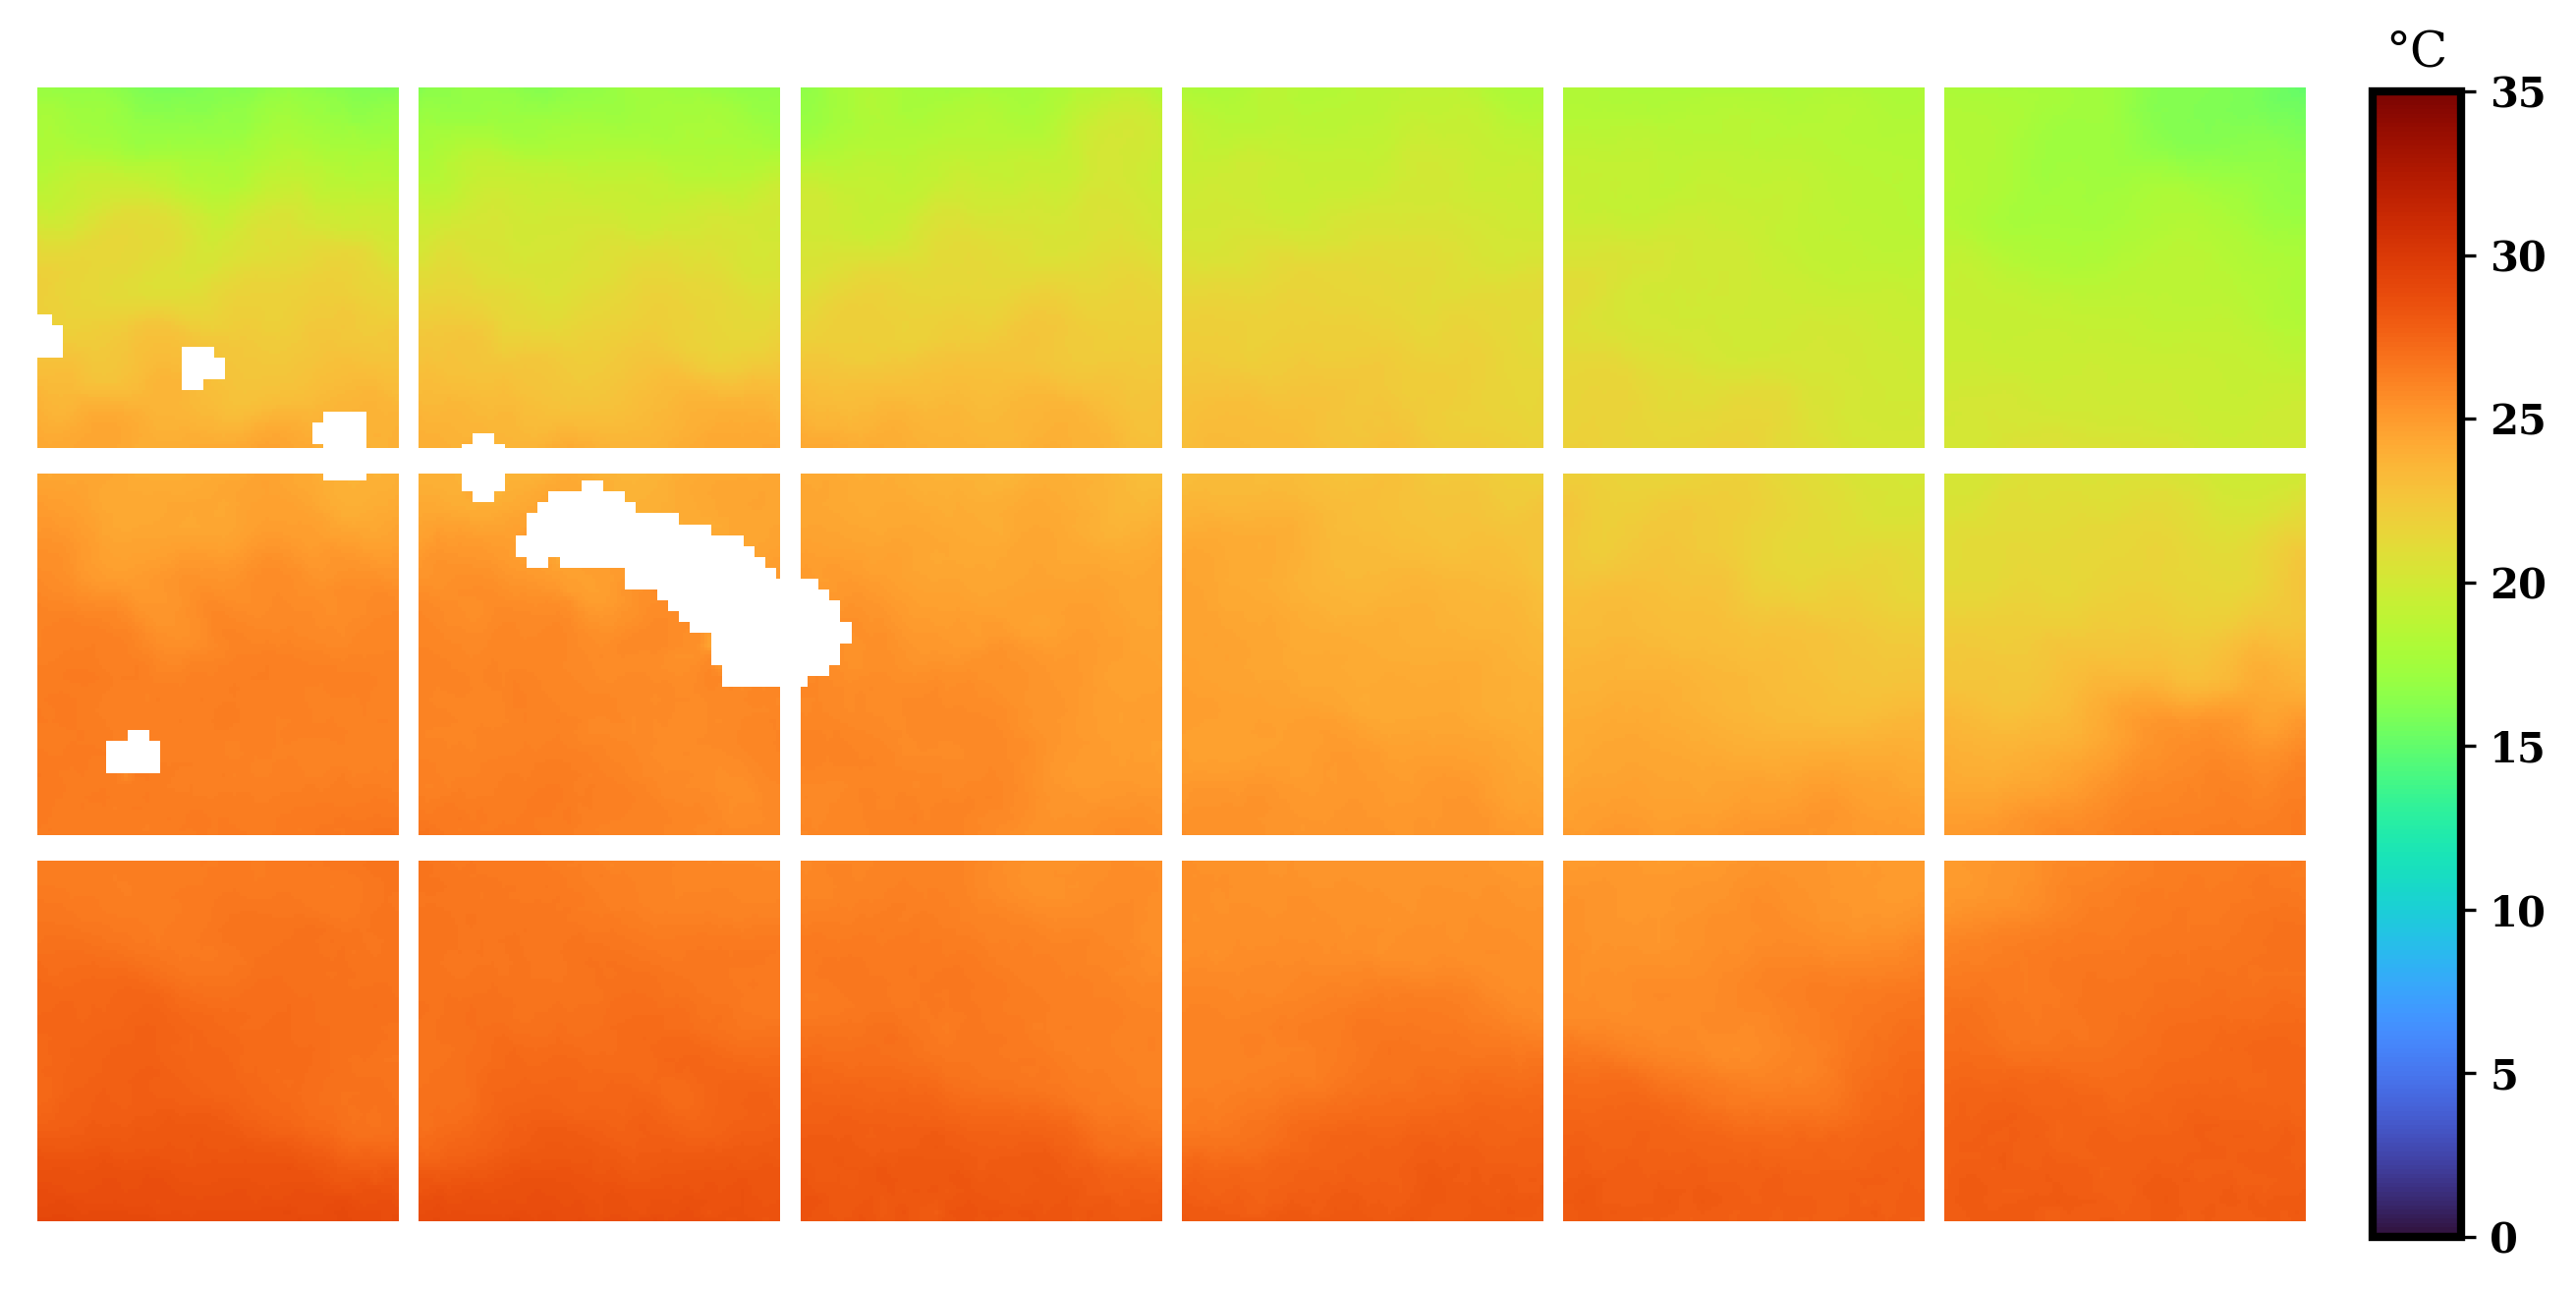

In [6]:
a = torch.load('../data/patches/case_1_amsre_2010_pacific_day.pt')
a.shape
jan = a[0]

hei=3
wid=6

fig = plt.figure(figsize=(10,5))
# plt.title(f'{date}_{satnames[idx]}_{oc}_{satt}')
plt.axis('off')
gs = gridspec.GridSpec(hei,
                       wid,
                       hspace=.07,
                       wspace=.01,
                       width_ratios=list(itertools.repeat(.1,wid)),
                       height_ratios=list(itertools.repeat(.1,hei))
                       )

for idy,i in enumerate(itertools.product(range(hei),range(wid))):
    fig.add_subplot(gs[i[0],i[1]])
    hey = plt.imshow(jan[idy,0],cmap='turbo',vmin=0,vmax=35)
    plt.axis('off')


im = plt.gca().get_children()[0]
cax = fig.add_axes([.92,0.1,0.03,0.777]) 
cbr = fig.colorbar(im, cax=cax,fraction=.02)
cbr.ax.set_title('°C');

plt.savefig('../figures/sample_tiling.png',bbox_inches='tight')

/scratch/gypsum-gpu126/4526458/ipykernel_204152/2113466928.py:47: RuntimeWarning: Mean of empty slice
  x1 = np.nanmean(x1,axis=0)
/scratch/gypsum-gpu126/4526458/ipykernel_204152/2113466928.py:53: RuntimeWarning: Mean of empty slice
  y1 = np.nanmean(y1,axis=0)
/scratch/gypsum-gpu126/4526458/ipykernel_204152/2113466928.py:47: RuntimeWarning: Mean of empty slice
  x1 = np.nanmean(x1,axis=0)
/scratch/gypsum-gpu126/4526458/ipykernel_204152/2113466928.py:53: RuntimeWarning: Mean of empty slice
  y1 = np.nanmean(y1,axis=0)
/scratch/gypsum-gpu126/4526458/ipykernel_204152/2113466928.py:47: RuntimeWarning: Mean of empty slice
  x1 = np.nanmean(x1,axis=0)
/scratch/gypsum-gpu126/4526458/ipykernel_204152/2113466928.py:53: RuntimeWarning: Mean of empty slice
  y1 = np.nanmean(y1,axis=0)
/scratch/gypsum-gpu126/4526458/ipykernel_204152/2113466928.py:47: RuntimeWarning: Mean of empty slice
  x1 = np.nanmean(x1,axis=0)
/scratch/gypsum-gpu126/4526458/ipykernel_204152/2113466928.py:53: RuntimeWarning: M

torch.Size([12, 18, 1, 100, 100])


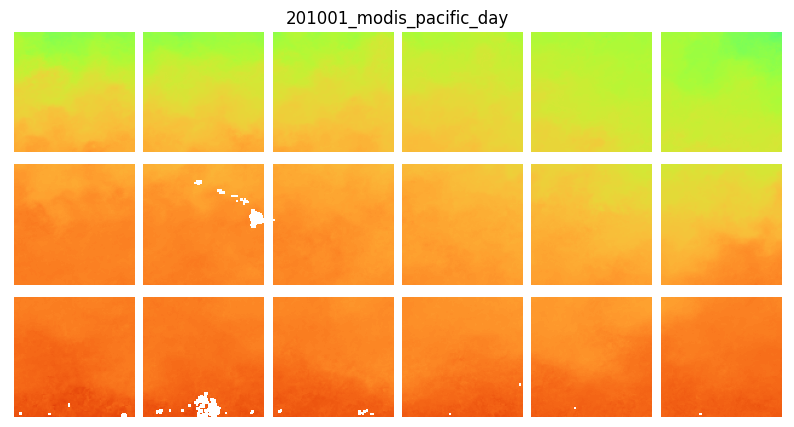

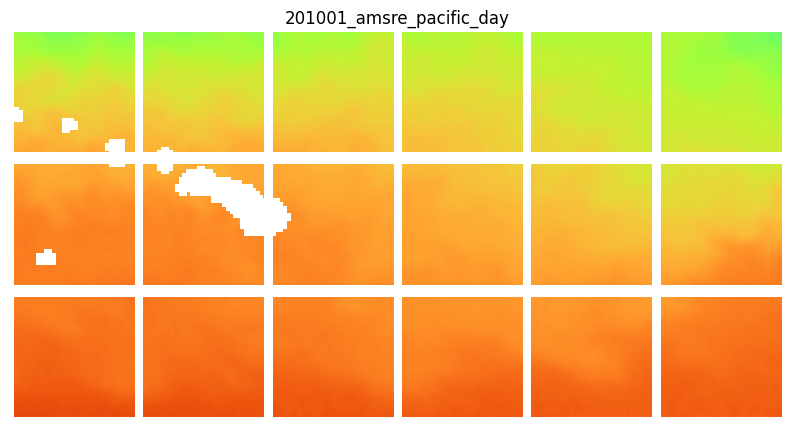

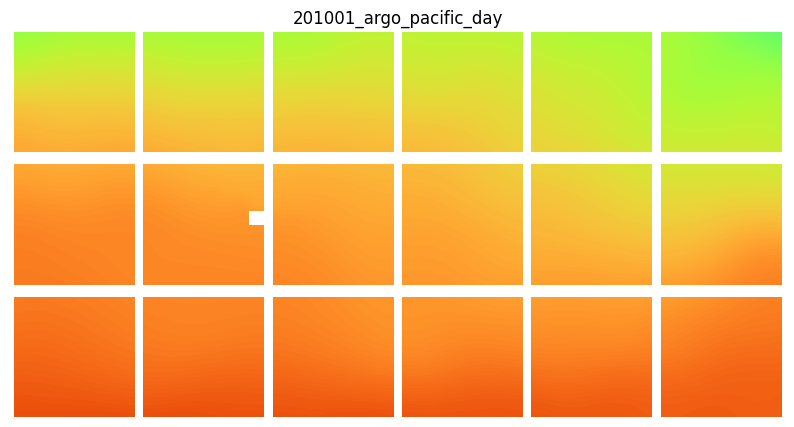

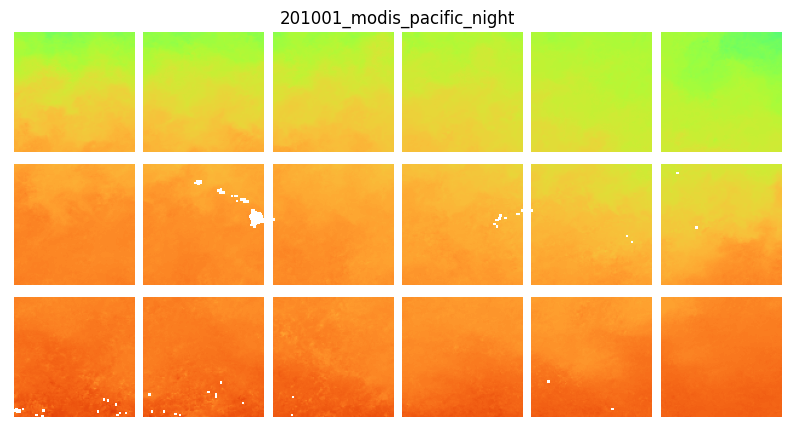

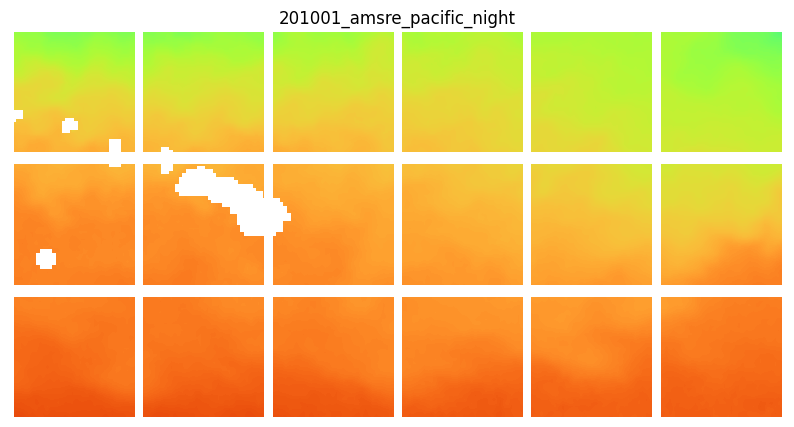

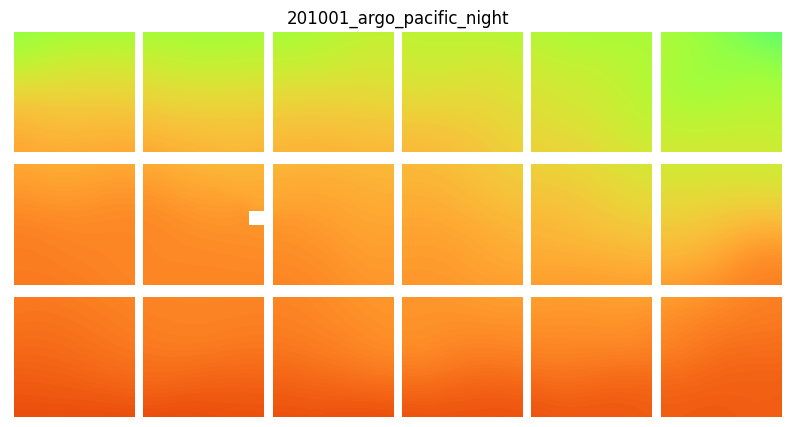

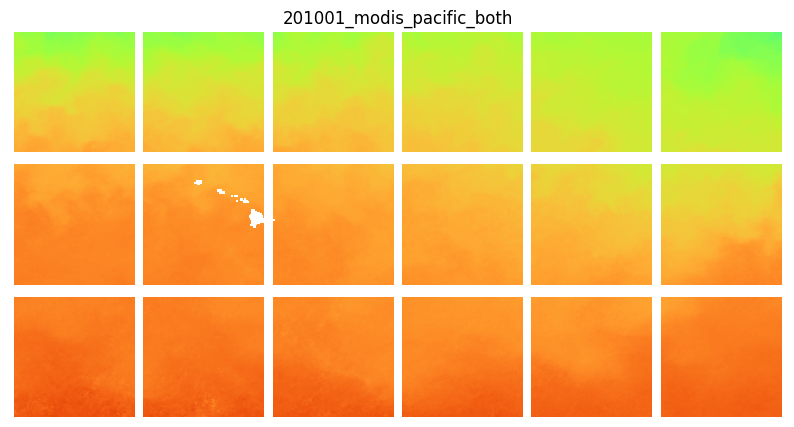

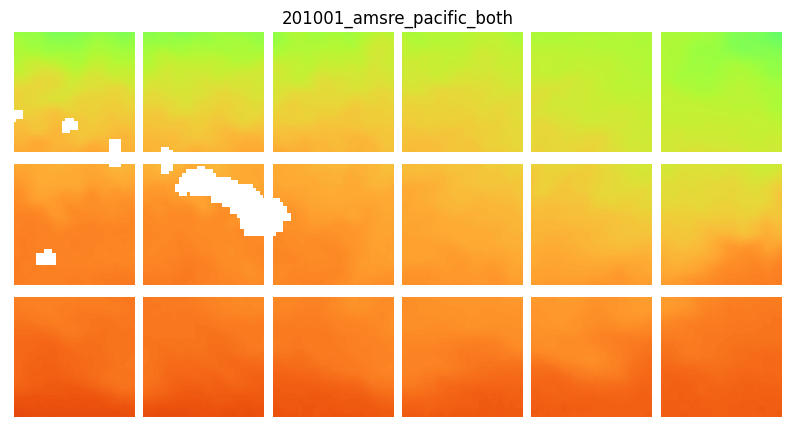

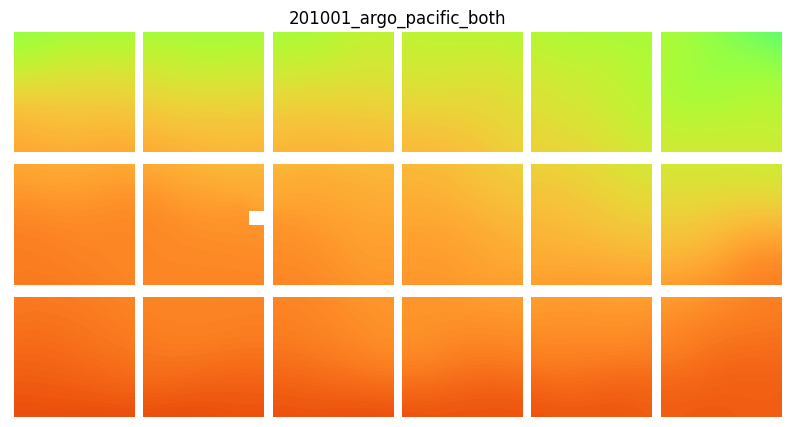

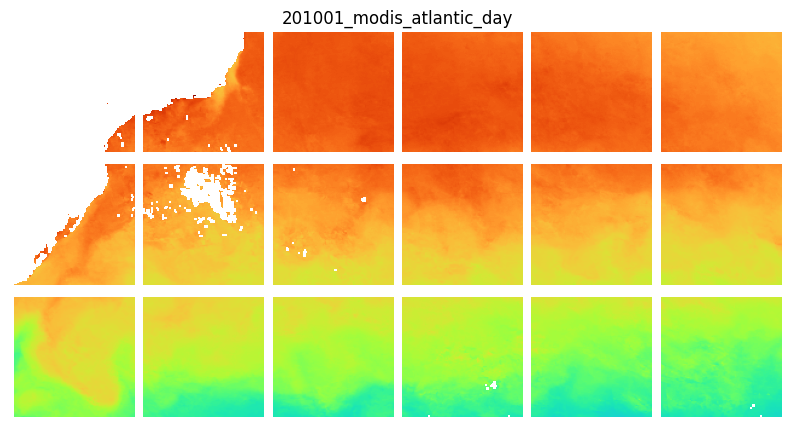

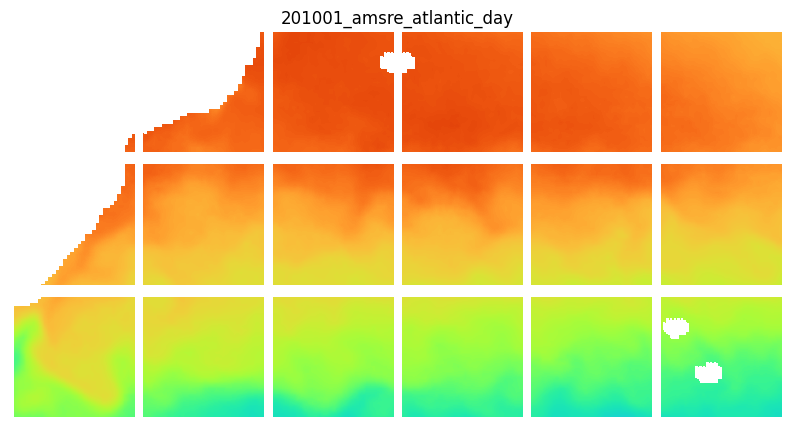

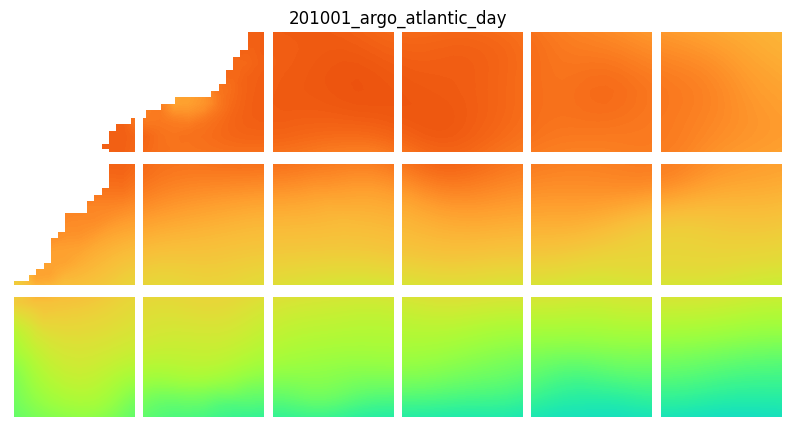

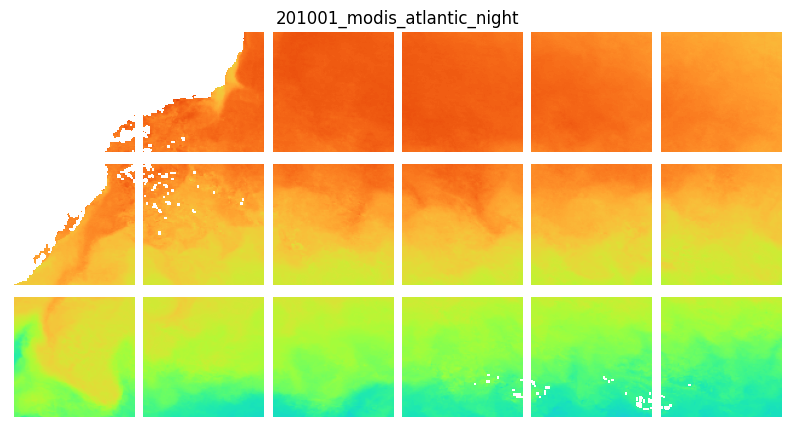

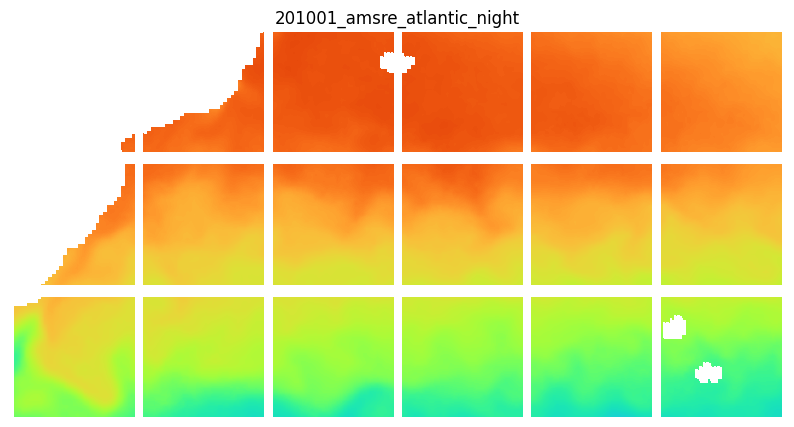

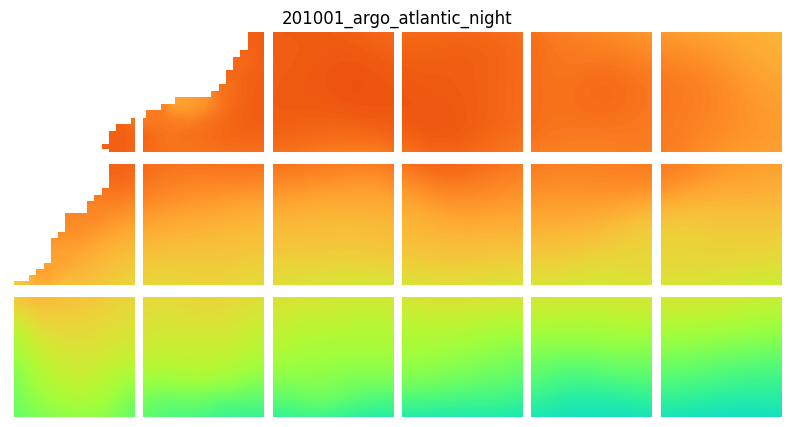

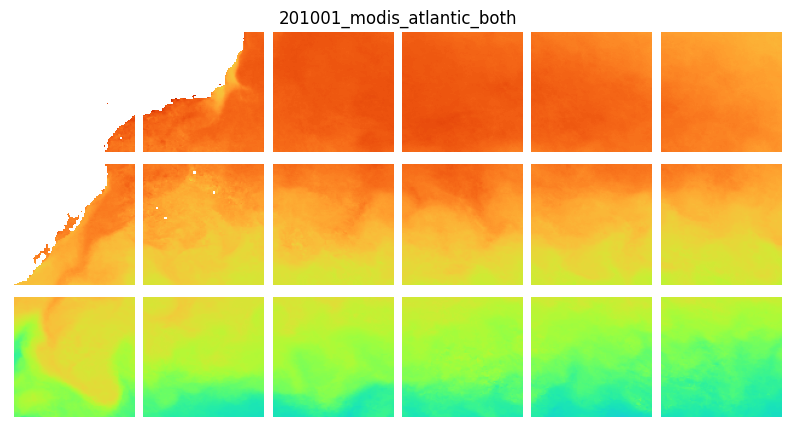

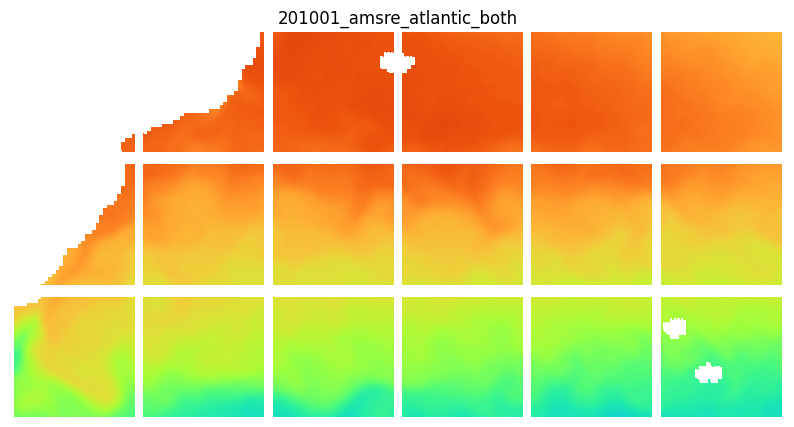

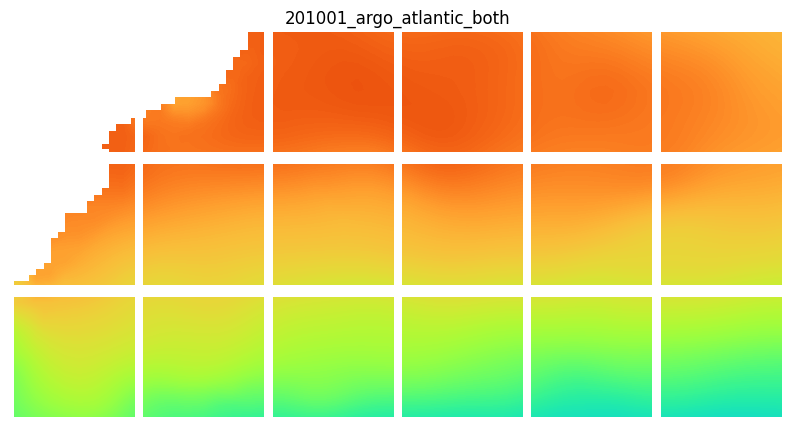

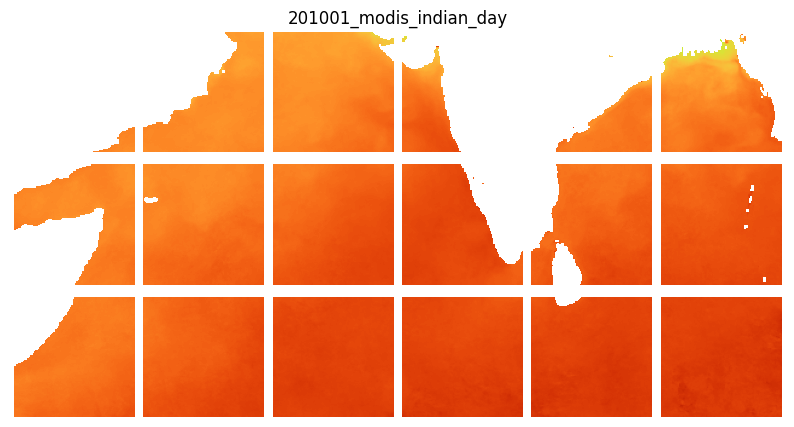

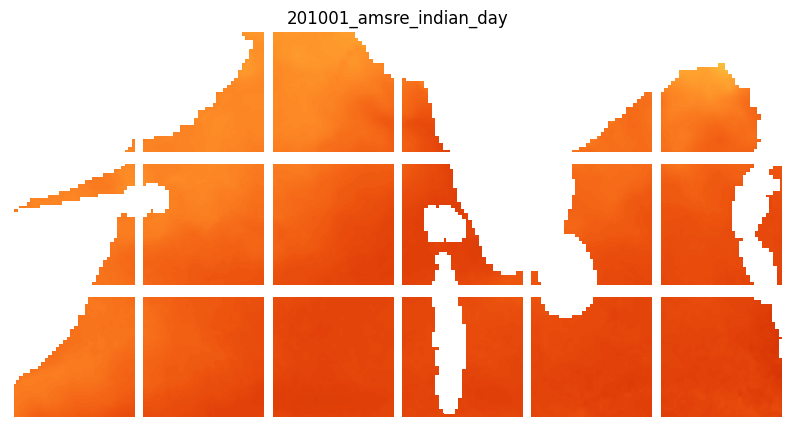

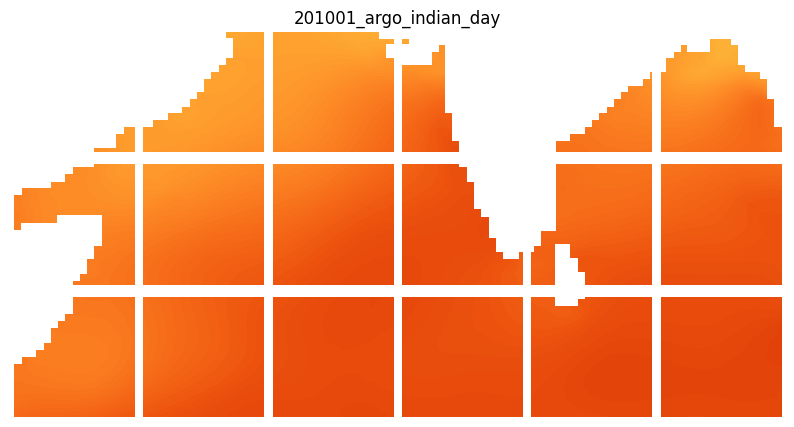

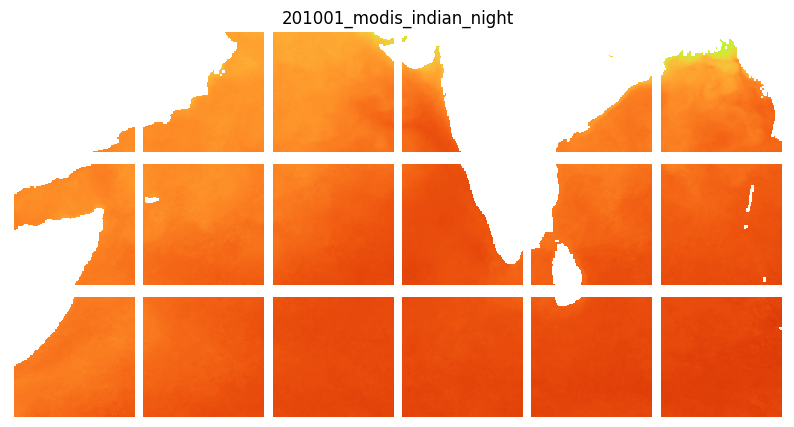

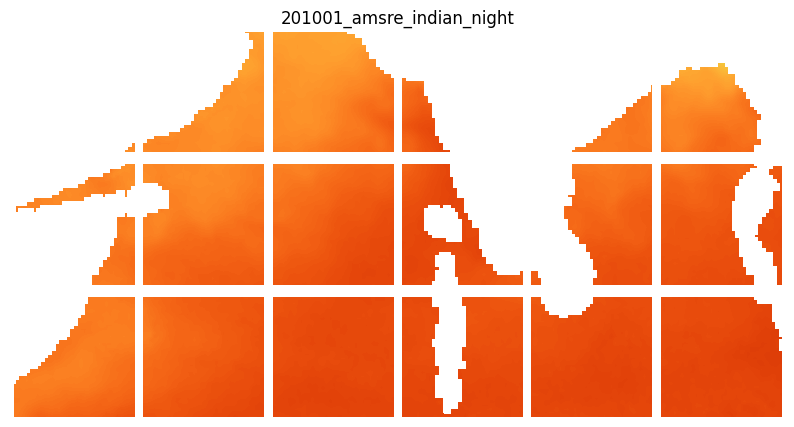

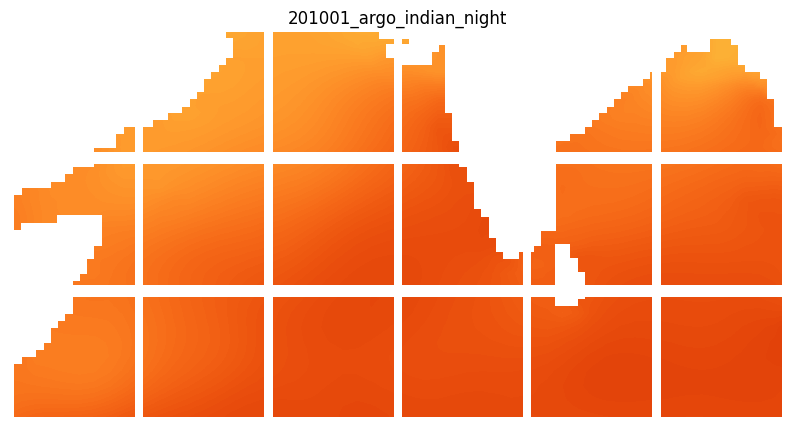

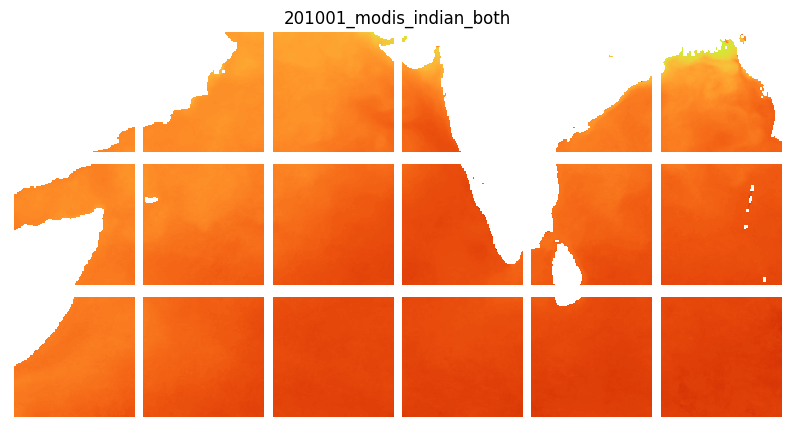

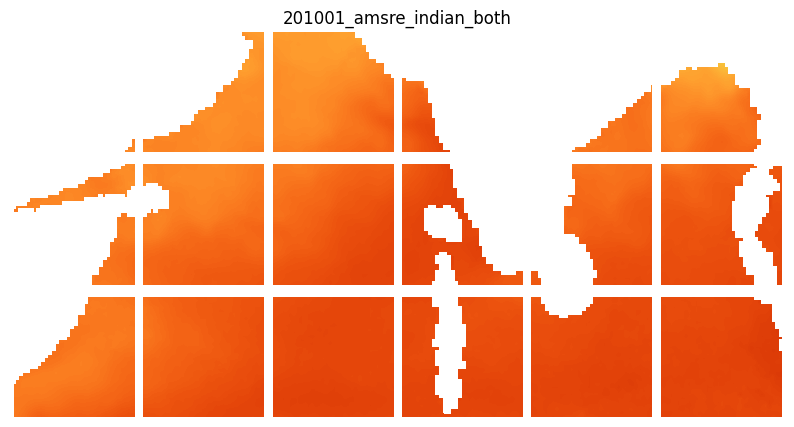

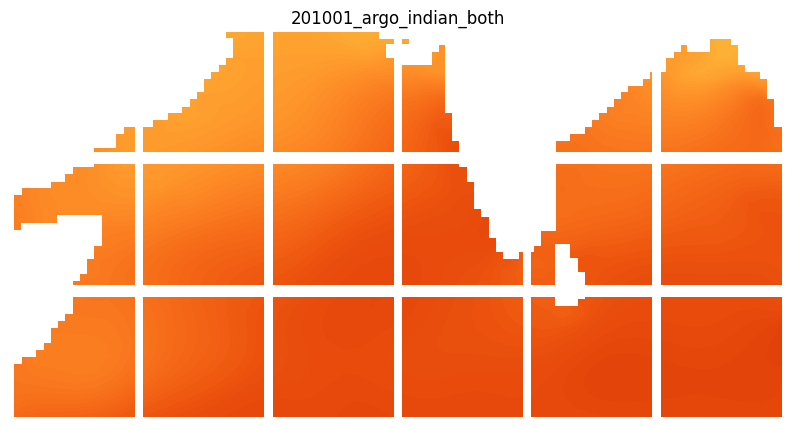

In [4]:
select_by_date = {}
for idx,i in enumerate(glob.glob('../data/argo/argo_regrid/*.nc')):
    select_by_date[i[25:31]] = idx
    
lake = sst_retro(2010)
    
def xarr2torch(x):
        return torch.from_numpy(np.asarray(x)).unsqueeze(0).unsqueeze(0).float()
def funct(satt,oc,patchsize,date,plotit):
    match oc:
        case 'pacific':
            lat_high = 700
            lat_low = lat_high+300
            lon_left = 100
            lon_right = lon_left+600
        case 'atlantic':
            lat_high = 1300
            lat_low = lat_high+300
            lon_left = 1500
            lon_right = lon_left+600
        case 'indian':
            lat_high = 800
            lat_low = lat_high+300
            lon_left = 2700
            lon_right = lon_left+600
            
    match satt:
        case 'day':
            x0 = xr.open_dataset(lake.amsre[select_by_date[date]])
            x1 = x0.sst_month[0]-273.15
            y0 = xr.open_dataset(lake.modis_day[select_by_date[date]])
            y1 = np.where(y0.qual_sst==0,y0.sst,np.nan)
            z0 = xr.open_dataset(lake.argo[select_by_date[date]])
            z1 = z0.TEMP[0]
        case 'night':
            x0 = xr.open_dataset(lake.amsre[select_by_date[date]])
            x1 = x0.sst_month[1]-273.15
            y0 = xr.open_dataset(lake.modis_night[select_by_date[date]])
            y1 = np.where(y0.qual_sst==0,y0.sst,np.nan)
            z0 = xr.open_dataset(lake.argo[select_by_date[date]])
            z1 = z0.TEMP[0]
        case 'both':
            x0 = xr.open_dataset(lake.amsre[select_by_date[date]])
            x1 = np.expand_dims(x0.sst_month[0]-273.15,0)
            x11 = np.expand_dims(x0.sst_month[1]-273.15,0)
            x1 = np.concatenate((x1,x11),0)
            x1 = np.nanmean(x1,axis=0)
            y0 = xr.open_dataset(lake.modis_night[select_by_date[date]])
            y1 = np.expand_dims(np.where(y0.qual_sst==0,y0.sst,np.nan),0)
            y11 = xr.open_dataset(lake.modis_day[select_by_date[date]])
            y11 = np.expand_dims(np.where(y11.qual_sst==0,y11.sst,np.nan),0)
            y1 = np.concatenate((y1,y11),0)
            y1 = np.nanmean(y1,axis=0)
            z0 = xr.open_dataset(lake.argo[select_by_date[date]])
            z1 = z0.TEMP[0]

    x1 = x1[lat_high:lat_low,lon_left:lon_right]
    y1 = y1[lat_high:lat_low,lon_left:lon_right]
    z1 = z1[lat_high:lat_low,lon_left:lon_right]

    
#     plt.figure()
#     plt.imshow(x1,cmap='turbo',vmin=0,vmax=35)
#     plt.colorbar(fraction=.02)

#     match ocean:
#         case 'pacific':
#             plt.gca().add_patch(matplotlib.patches.Rectangle((100,700),600,300,linewidth=2,edgecolor='black',facecolor='none'))
#         case 'atlantic':
#             plt.gca().add_patch(matplotlib.patches.Rectangle((1500,1300),600,300,linewidth=2,edgecolor='black',facecolor='none'))
#         case 'indian':
#             plt.gca().add_patch(matplotlib.patches.Rectangle((2700,800),600,300,linewidth=2,edgecolor='black',facecolor='none'))

    unfoldobj = torch.nn.Unfold(kernel_size = (patchsize,patchsize),stride=int((patchsize/1)))
    amsre_patches = unfoldobj(xarr2torch(x1)).permute(2,0,1).reshape(-1,1,patchsize,patchsize)
    modis_patches = unfoldobj(xarr2torch(y1)).permute(2,0,1).reshape(-1,1,patchsize,patchsize)
    argo_patches = unfoldobj(xarr2torch(z1)).permute(2,0,1).reshape(-1,1,patchsize,patchsize)
    # print(patches.shape)

    hei = 3
    wid = 6
    
    satnames = ['modis','amsre','argo']
    match plotit:
        case 'yes':
            for idx,x in enumerate([modis_patches,amsre_patches,argo_patches]):

                fig = plt.figure(figsize=(10,5))
                plt.title(f'{date}_{satnames[idx]}_{oc}_{satt}')
                plt.axis('off')
                gs = gridspec.GridSpec(hei,
                                       wid,
                                       hspace=.1,
                                       wspace=.01,
                                       width_ratios=list(itertools.repeat(.1,wid)),
                                       height_ratios=list(itertools.repeat(.1,hei))
                                       )

                for idy,i in enumerate(itertools.product(range(hei),range(wid))):
                    fig.add_subplot(gs[i[0],i[1]])
                    plt.imshow(x[idy,0],cmap='turbo',vmin=0,vmax=35)
                    plt.axis('off')

                plt.savefig(f'../figures/patch_region_examples/{date}_{satnames[idx]}_{oc}_{satt}.png',bbox_inches='tight')
            # print('chose not to plot this month')
    return x1,y1,z1,amsre_patches,modis_patches,argo_patches

ocean = ['pacific','atlantic','indian']
sattime = ['day','night','both']
case = 0
for k in ocean:
    for j in sattime:
        case+=1
        for idx,i in enumerate(select_by_date):
            if idx == 0:
                amsre,modis,argo,amsre_patches,modis_patches,argo_patches = funct(satt=j,oc=k,patchsize=100,date=i,plotit='yes')
                amsre_comp_2010 = torch.unsqueeze(amsre_patches,0)
                modis_comp_2010 = torch.unsqueeze(modis_patches,0)
                argo_comp_2010 = torch.unsqueeze(argo_patches,0)
            elif idx == 11:
                amsre,modis,argo,amsre_patches,modis_patches,argo_patches = funct(satt=j,oc=k,patchsize=100,date=i,plotit='no')
                amsre_patches = torch.unsqueeze(amsre_patches,0)
                modis_patches = torch.unsqueeze(modis_patches,0)
                argo_patches = torch.unsqueeze(argo_patches,0)
                amsre_comp_2010 = torch.cat((amsre_comp_2010,amsre_patches),dim=0)
                modis_comp_2010 = torch.cat((modis_comp_2010,modis_patches),dim=0)
                argo_comp_2010 = torch.cat((argo_comp_2010,argo_patches),dim=0)

                torch.save(amsre_comp_2010,f'../data/patches/case_{case}_amsre_2010_{k}_{j}.pt')
                torch.save(modis_comp_2010,f'../data/patches/case_{case}_modis_2010_{k}_{j}.pt')
                torch.save(argo_comp_2010,f'../data/patches/case_{case}_argo_2010_{k}_{j}.pt')
            else:
                amsre,modis,argo,amsre_patches,modis_patches,argo_patches = funct(satt=j,oc=k,patchsize=100,date=i,plotit='no')
                amsre_patches = torch.unsqueeze(amsre_patches,0)
                modis_patches = torch.unsqueeze(modis_patches,0)
                argo_patches = torch.unsqueeze(argo_patches,0)
                amsre_comp_2010 = torch.cat((amsre_comp_2010,amsre_patches),dim=0)
                modis_comp_2010 = torch.cat((modis_comp_2010,modis_patches),dim=0)
                argo_comp_2010 = torch.cat((argo_comp_2010,argo_patches),dim=0)
print(amsre_comp_2010.shape)


pick one:	['atlantic', 'pacific', 'indian']	 atlantic
pick one:	['amsre_night', 'amsre_day', 'modis_night', 'modis_day']	 modis_night


torch.Size([1, 1, 300, 600])
torch.Size([18, 1, 100, 100])


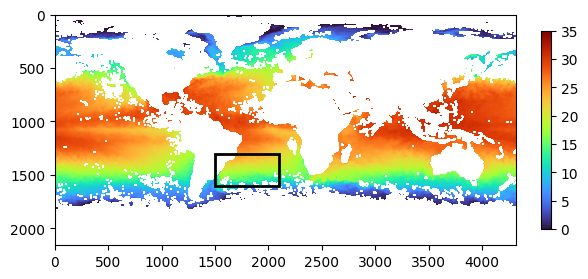

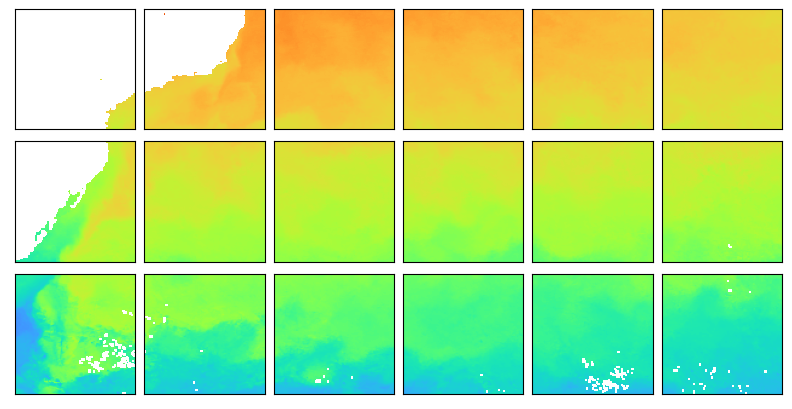

In [100]:
##what i'm trying to optimize

import glob
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
import torch
import numpy as np

class sst_retro:
    def __init__(self,year):
        self.year = year
        self.argo = sorted(glob.glob(f'../data/argo/argo_regrid/{self.year}*.nc'))
        self.amsre = sorted(glob.glob(f'../data/amsre/regrid_to_modis/{self.year}*'))
        self.modis_day = sorted(glob.glob(f'../data/modis/{self.year}/*.SST*.nc'))
        self.modis_night = sorted(glob.glob(f'../data/modis/{self.year}/*.NSST*.nc'))

lake = sst_retro(2010)

select_by_date = {}
for idx,i in enumerate(x):
    select_by_date[i[25:31]] = idx + 1

date = ['201001','201002']


ocean = ['atlantic','pacific','indian']

cheese = True
while cheese == True:
    loc_selector = input(f'pick one:\t{ocean}\t')
    if loc_selector == 'pacific':
        lat_high = 700
        lat_low = lat_high+300
        lon_left = 100
        lon_right = lon_left+600
        
        cheese = False
        
    elif loc_selector == 'atlantic':
        lat_high = 1300
        lat_low = lat_high+300
        lon_left = 1500
        lon_right = lon_left+600
        
        cheese = False
        
    elif loc_selector == 'indian':
        lat_high = 800
        lat_low = lat_high+300
        lon_left = 2700
        lon_right = lon_left+600
        
        cheese = False
        
    else:
        continue

sats = ['amsre_night','amsre_day','modis_night','modis_day']
dog = True

while dog == True: 
    sat_selector = input(f'pick one:\t{sats}\t')
    if sat_selector == 'amsre_day':
        x0 = xr.open_dataset(lake.amsre[select_by_date[date]])
        x1 = x0.sst_month[0]-273.15
        
        dog = False
        
    elif sat_selector == 'amsre_night':
        x0 = xr.open_dataset(lake.amsre[select_by_date[date]])
        x1 = x0.sst_month[1]-273.15
        
        dog = False
        
    elif sat_selector == 'modis_day':
        x0 = xr.open_dataset(lake.modis_day[select_by_date[date]])
        x1 = np.where(x0.qual_sst==0,x0.sst,np.nan)
        
        dog = False
    
    elif sat_selector == 'modis_night':
        x0 = xr.open_dataset(lake.modis_day[select_by_date[date]])
        x1 = np.where(x0.qual_sst==0,x0.sst,np.nan)

        dog = False
    
    else:
        print('try again')
        
    
x2 = x1[lat_high:lat_low,lon_left:lon_right]

plt.figure()
plt.imshow(x1,cmap='turbo',vmin=0,vmax=35)
plt.colorbar(fraction=.02)

match loc_selector:
    case 'pacific':
        plt.gca().add_patch(matplotlib.patches.Rectangle((100,700),600,300,linewidth=2,edgecolor='black',facecolor='none'))
    case 'atlantic':
        plt.gca().add_patch(matplotlib.patches.Rectangle((1500,1300),600,300,linewidth=2,edgecolor='black',facecolor='none'))
    case 'indian':
        plt.gca().add_patch(matplotlib.patches.Rectangle((2700,800),600,300,linewidth=2,edgecolor='black',facecolor='none'))


patchsize = 100
unfoldobj = torch.nn.Unfold(kernel_size = (patchsize,patchsize),stride=int((patchsize/1)))

def xarr2torch(x):
    return torch.from_numpy(np.asarray(x)).unsqueeze(0).unsqueeze(0).float()

print(xarr2torch(x2).shape)

patches = unfoldobj(xarr2torch(x2)).permute(2,0,1).reshape(-1,1,patchsize,patchsize)
print(patches.shape)

hei = 3
wid = 6

fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(hei,
                       wid,
                       hspace=.1,
                       wspace=.01,
                       width_ratios=list(itertools.repeat(.1,wid)),
                       height_ratios=list(itertools.repeat(.1,hei))
                       )

for idx,i in enumerate(itertools.product(range(hei),range(wid))):
    fig.add_subplot(gs[i[0],i[1]])
    plt.imshow(patches[idx,0],cmap='turbo',vmin=0,vmax=35)
    plt.xticks([])
    plt.yticks([])
plt.savefig(f'{date}{loc_selector}{sat_selector}.png',bbox_inches='tight')

/work/albertl_uri_edu/.conda/envs/sst/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor(0.2827, grad_fn=<SqueezeBackward0>) 0.9987432480762874 tensor(0.8913) tensor(18.6851) tensor(0.0135)
tensor(0.2944, grad_fn=<SqueezeBackward0>) 0.9978842477967858 tensor(0.8870) tensor(17.0232) tensor(0.0198)
tensor(0.2832, grad_fn=<SqueezeBackward0>) 0.9988295742155329 tensor(0.9007) tensor(19.5449) tensor(0.0111)
tensor(0.3158, grad_fn=<SqueezeBackward0>) 0.9955491665438173 tensor(0.9067) tensor(15.7728) tensor(0.0265)
tensor(0.3765, grad_fn=<SqueezeBackward0>) 0.9812200852347951 tensor(0.8578) tensor(11.7181) tensor(0.0673)
tensor(0.2591, grad_fn=<SqueezeBackward0>) 0.9990995318519283 tensor(0.9224) tensor(24.4088) tensor(0.0036)
tensor(0.3135, grad_fn=<SqueezeBackward0>) 0.990620031067836 tensor(0.7945) tensor(10.7884) tensor(0.0834)
tensor(0.2790, grad_fn=<SqueezeBackward0>) 0.9944809475140614 tensor(0.8299) tensor(13.4042) tensor(0.0457)
tensor(0.3090, grad_fn=<SqueezeBackward0>) 0.9938199600957672 tensor(0.7754) tensor(12.7455) tensor(0.0531)
tensor(0.2853, grad_fn=<Squee

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

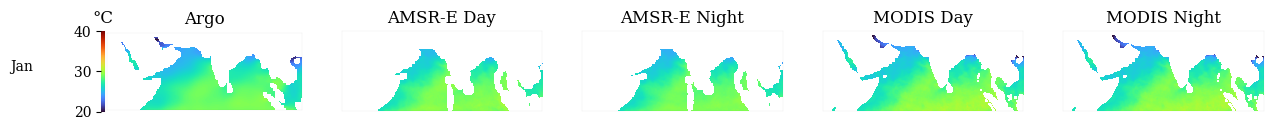

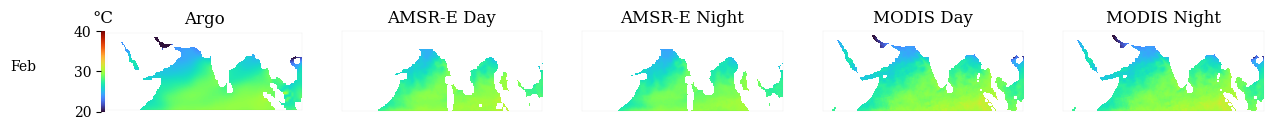

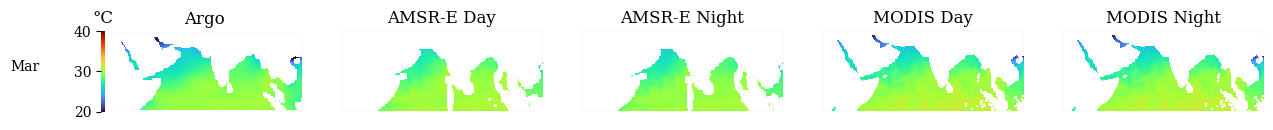

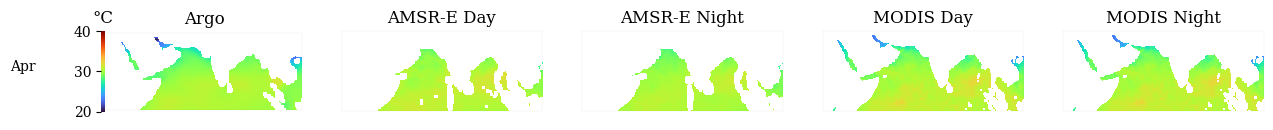

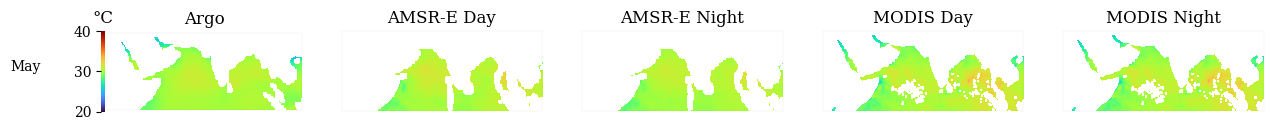

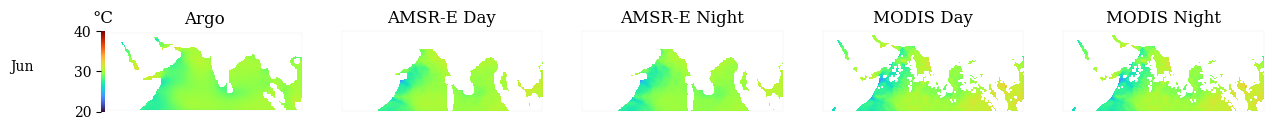

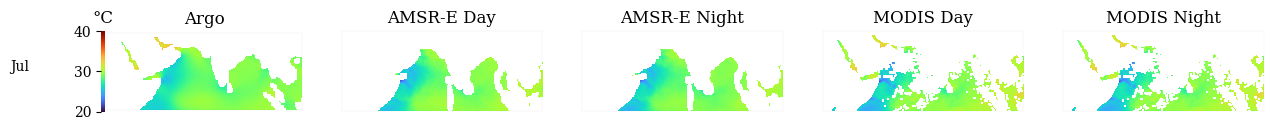

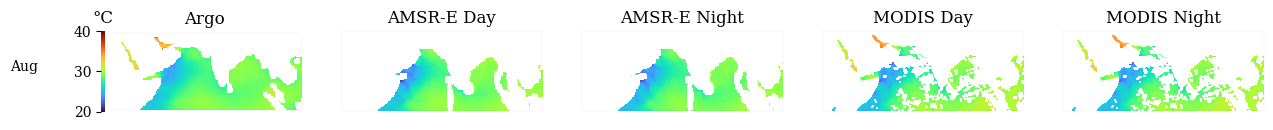

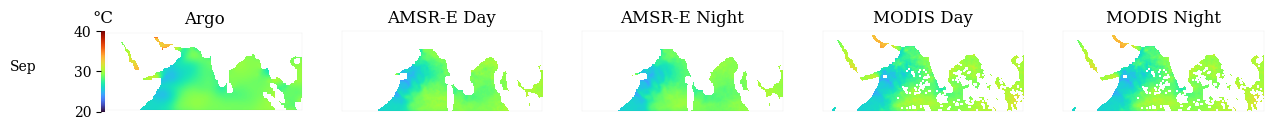

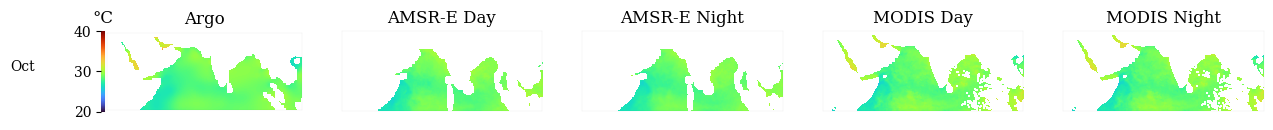

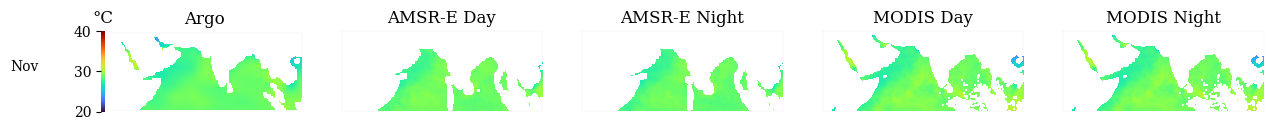

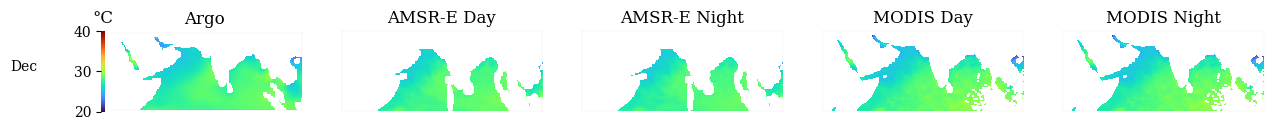

In [2]:
import glob
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import hydroeval as he
import torch
import torchmetrics
import skimage
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

mseobj = torchmetrics.MeanSquaredError()
ssimtorchobj = torchmetrics.StructuralSimilarityIndexMeasure()
psnrobj = torchmetrics.PeakSignalNoiseRatio()
lpipsobj = LearnedPerceptualImagePatchSimilarity(net_type='vgg')

class sst_retro:
    def __init__(self,year):
        self.year = year
        self.argo = sorted(glob.glob(f'../data/argo/argo_regrid/{self.year}*.nc'))
        self.amsre = sorted(glob.glob(f'../data/amsre/regrid_to_modis/{self.year}*'))
        self.modis_day = sorted(glob.glob(f'../data/modis/{self.year}/*.SST*.nc'))
        self.modis_night = sorted(glob.glob(f'../data/modis/{self.year}/*.NSST*.nc'))
lake = sst_retro(2010)


# year_of_study = 2010
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
mon_abbrev = [i[:3] for i in months]

plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams['axes.linewidth'] = .02
plt.rcParams['figure.dpi'] = 100


metric_grid = []
for idx,i in enumerate(lake.argo):
    fig = plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(1,5,width_ratios=(.2,.2,.2,.2,.2),hspace=.2,wspace=.2)
    j = xr.open_dataset(i)
    
    fig.add_subplot(gs[0,0])
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.annotate(f'{mon_abbrev[idx]}',xy=(0,0),xytext=(-.5,0.5),xycoords='axes fraction')
    plt.imshow(j.TEMP[0][700:1100,2500:3500],cmap='turbo',vmin=20,vmax=40)
    cbr = plt.colorbar(fraction=.02,pad=.01,location='left',orientation='vertical')
    cbr.ax.set_title('°C');
    plt.title(f'Argo')    
    
    fig.add_subplot(gs[0,1])
    plt.gca().set_aspect('equal')
    k = xr.open_dataset(lake.amsre[idx])
    plt.imshow(k.sst_month[0][700:1100,2500:3500]-273.15,cmap='turbo',vmin=20,vmax=40)
    plt.xticks([])
    plt.yticks([])
    plt.title('AMSR-E Day')
        
    fig.add_subplot(gs[0,2])
    plt.imshow(k.sst_month[1][700:1100,2500:3500]-273.15,cmap='turbo',vmin=20,vmax=40)
    plt.xticks([])
    plt.yticks([])
    plt.title('AMSR-E Night')
    
    fig.add_subplot(gs[0,3])
    plt.gca().set_aspect('equal')
    l = xr.open_dataset(lake.modis_day[idx])
    l1 = np.where(l.qual_sst==0,l.sst,np.nan)
    plt.imshow(l1[700:1100,2500:3500],cmap='turbo',vmin=20,vmax=40)
    plt.xticks([])
    plt.yticks([])
    plt.title('MODIS Day')
    
    fig.add_subplot(gs[0,4])
    plt.gca().set_aspect('equal')
    m = xr.open_dataset(lake.modis_night[idx])
    m1 = np.where(m.qual_sst==0,m.sst,np.nan)
    plt.imshow(l1[700:1100,2500:3500],cmap='turbo',vmin=20,vmax=40)
    plt.xticks([])
    plt.yticks([])
    plt.title('MODIS Night')
    
    def whiten(x):
        x1 = np.nanmax(x)
        x2 = np.nanmin(x)
        x3 = np.where(np.abs((x-x2)/(x1-x2)>1000),np.nanmean((x-x2)/(x1-x2)),((x-x2)/(x1-x2)))
        return x3
    
    
    ##argo
    a = np.asarray(j.TEMP[0][700:1100,2500:3500])
    a = np.where(np.isfinite(a)==False,np.nanmean(a),a)

    a1 = whiten(a)
    a2 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(a1),0),0)

    
    b = np.asarray(k.sst_month[0][700:1100,2500:3500]-273.15)
    b = np.where(np.isfinite(b)==False,np.nanmean(b),b)
    b1 = whiten(b)
    b2 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(b1),0),0)
    
    nse = np.nanmean(he.nse(b1,a1))
    ssimtorch = ssimtorchobj(a2,b2)
    psnr = psnrobj(a2,b2)
    mse = mseobj(a2,b2)
    lpips = lpipsobj(torch.tile(a2,(1,3,1,1)), torch.tile(b2,(1,3,1,1)))
    
    
    metric_grid.append((lpips,nse,ssimtorch,psnr,mse))
    print(lpips,nse,ssimtorch,psnr,mse)
    
metric_grid = np.asarray(metric_grid)
np.save('metric_grid_test.npy',metric_grid)

In [19]:
met = torch.Tensor(metric_grid)
torch.save(met,'../data/grid_of_metric_test.pt')

In [6]:
import torch

lpips = LearnedPerceptualImagePatchSimilarity(net_type='vgg')
 # LPIPS needs the images to be in the [-1, 1] range.

lpips(torch.tile(a2,(1,3,1,1)), torch.tile(b2,(1,3,1,1)))

tensor(0.2832, grad_fn=<SqueezeBackward0>)

In [13]:
import torch
import torchmetrics

In [2]:
from torchmetrics.image.fid import FrechetInceptionDistance

/work/albertl_uri_edu/.conda/envs/sst/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
FID = FrechetInceptionDistance(normalize=True)

In [6]:
b3 = torch.tile(b2,(1,3,1,1))
a3 = torch.tile(a2,(1,3,1,1))

FID.update(a3,real=True)
FID.update(b3,real=False)

fid = FID.compute()

/work/albertl_uri_edu/.conda/envs/sst/lib/python3.10/site-packages/scipy/linalg/_matfuncs_sqrtm.py:189: RuntimeWarning: invalid value encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


In [1]:
import skimage.metrics

In [1]:
import hydroeval as he

In [9]:
import statsmodels.api as sm

In [ ]:
sm.stats.ttest_ind(a,b,alternative='two-sided',usevar='unequal',weights=(None, None), value=0)

In [11]:
sm.ttest_ind(x1, x2, alternative='two-sided', usevar='pooled', weights=(None, None), value=0)

Ttest_relResult(statistic=nan, pvalue=nan)

(2160, 4320)
(2160, 4320)


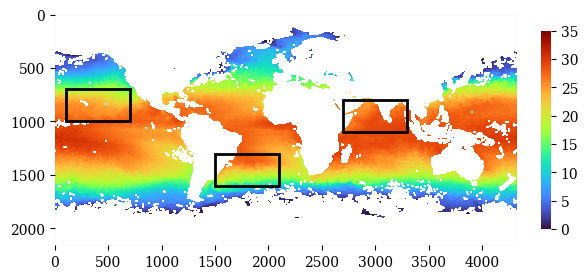

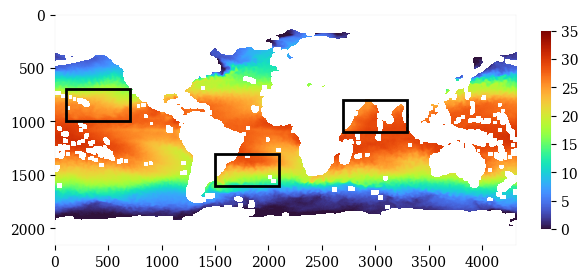

In [3]:
#amsre

x = xr.open_dataset(lake.amsre[0])
x = np.flipud(x.sst_month[1])
x = x-273.15
x = Image.fromarray(x)
(width, height) = (x.width * 3, x.height * 3)
x = np.asarray(x.resize((width, height)))
print(x.shape)
x1 = xr.open_dataset(lake.modis_night[0])

plt.figure()
plt.imshow(x1.sst,cmap='turbo',vmin=0,vmax=35)
plt.gca().add_patch(patches.Rectangle((100,700),600,300,linewidth=2,edgecolor='black',facecolor='none'))
plt.gca().add_patch(patches.Rectangle((1500,1300),600,300,linewidth=2,edgecolor='black',facecolor='none'))
plt.gca().add_patch(patches.Rectangle((2700,800),600,300,linewidth=2,edgecolor='black',facecolor='none'))
plt.colorbar(fraction=.02)


plt.figure()
plt.imshow(x,cmap='turbo',vmin=0,vmax=35)
plt.gca().add_patch(patches.Rectangle((100,700),600,300,linewidth=2,edgecolor='black',facecolor='none'))
plt.gca().add_patch(patches.Rectangle((1500,1300),600,300,linewidth=2,edgecolor='black',facecolor='none'))
plt.gca().add_patch(patches.Rectangle((2700,800),600,300,linewidth=2,edgecolor='black',facecolor='none'))
plt.colorbar(fraction=.02)


print(x1.sst.shape)

In [4]:
import xesmf as xe

In [ ]:
argo = xr.open_dataset(lake.argo[0])
argo

<xarray.Dataset>
Dimensions:      (longitude: 720, latitude: 545, time: 1)
Coordinates:
  * longitude    (longitude) float32 -180.0 -179.5 -179.0 ... 178.5 179.0 179.5
  * latitude     (latitude) float32 -77.01 -76.9 -76.78 ... 89.49 89.69 89.9
    depth        float32 ...
  * time         (time) datetime64[ns] 2010-01-15
Data variables:
    TEMP         (time, latitude, longitude) float32 ...
    TEMP_ERR     (time, latitude, longitude) float32 ...
    TEMP_PCTVAR  (time, latitude, longitude) float32 ...
Attributes: (12/20)
    Conventions:            CF-1.4
    title:                  Monthly analysis
    history:                20210706T131544L : Creation
    institution:            LOPS/IFREMER/IUEM
    project_name:           ISASLOPS
    analysis_name:          ISAS20_ARGO_
    ...                     ...
    start_date:             2010-01-15
    stop_date:              2010-01-15
    creation_date:          20210706T131544L
    reference_date:         1950-01-01T00:00:00Z
    references:             Gaillard et al., JCLIM 2016, Doi:10.1175/JCLI-D-1...
    comment:                V8.0 T and S fields

In [67]:
amsre = xr.open_dataset(lake.amsre[0])
amsre

<xarray.Dataset>
Dimensions:    (time: 2, lat: 720, lon: 1440)
Coordinates:
  * lon        (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat        (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * time       (time) object 'ascending' 'descending'
Data variables:
    sst_month  (time, lat, lon) float32 ...

In [69]:
modis = xr.open_dataset(lake.modis_night[0])
modis

<xarray.Dataset>
Dimensions:   (lat: 2160, lon: 4320, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat       (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon       (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    sst       (lat, lon) float32 ...
    qual_sst  (lat, lon) float32 ...
    palette   (rgb, eightbitcolor) uint8 ...
Attributes: (12/59)
    product_name:                     AQUA_MODIS.20100101_20100131.L3m.MO.NSS...
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    temporal_range:                   month
    ...                               ...
    publisher_url:                    https://oceandata.sci.gsfc.nasa.gov
    processing_level:                 L3 Mapped
    cdm_data_type:                    grid
    data_bins:                        4851870
    data_minimum:                     -1.7049999
    data_maximum:                     32.92543

In [70]:
regridding_object = xe.Regridder(amsre,modis,method='bilinear')

In [71]:
regridding_object.to_netcdf()

'bilinear_720x1440_2160x4320.nc'

In [54]:
def regrid_argo(month,argo,modis,weights):
    argoopen = xr.open_dataset(argo)
    modisopen = xr.open_dataset(modis)
    regrid = xe.Regridder(argoopen,modisopen,method='bilinear',weights=weights)
    newargo = regrid(argoopen)
    newargo.to_netcdf(f'../data/argo/argo_regrid/{month}_argoregrid.nc')
    return newargo

weights = xr.open_dataset('argo_to_modis_weights__bilinear_545x720_2160x4320.nc')

for i in lake.argo:
    month = re.findall('20[0-9]..[0-9]',i)[0]
    newargo = regrid_argo(month,i,lake.modis_night[0],weights)
    print(month)

201001
201002
201003
201004
201005
201006
201007
201008
201009
201010
201011
201012


In [28]:
mask = xr.open_dataset('../data/GLDASp5_landmask_025d.nc4')
mask

modgrid = xr.open_dataset('../data/modis/2010/AQUA_MODIS.20100101_20100131.L3m.MO.NSST.sst.9km.nc')
modgrid

<xarray.Dataset>
Dimensions:   (lat: 2160, lon: 4320, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat       (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon       (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    sst       (lat, lon) float32 ...
    qual_sst  (lat, lon) float32 ...
    palette   (rgb, eightbitcolor) uint8 ...
Attributes: (12/59)
    product_name:                     AQUA_MODIS.20100101_20100131.L3m.MO.NSS...
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    temporal_range:                   month
    ...                               ...
    publisher_url:                    https://oceandata.sci.gsfc.nasa.gov
    processing_level:                 L3 Mapped
    cdm_data_type:                    grid
    data_bins:                        4851870
    data_minimum:                     -1.7049999
    data_maximum:                     32.92543

In [ ]:
def regrid_argo(month,argo,modis,weights):
    argoopen = xr.open_dataset(argo)
    modisopen = xr.open_dataset(modis)
    regrid = xe.Regridder(argoopen,modisopen,method='bilinear',weights=weights)
    newargo = regrid(argoopen)
    newargo.to_netcdf(f'../data/argo/argo_regrid/{month}_argoregrid.nc')
    return newargo

weights = xr.open_dataset('argo_to_modis_weights__bilinear_545x720_2160x4320.nc')

for i in lake.argo:
    month = re.findall('20[0-9]..[0-9]',i)[0]
    newargo = regrid_argo(month,i,lake.modis_night[0],weights)
    print(month)

In [29]:
import xesmf as xe

In [30]:
grid_ob = xe.Regridder(mask,modgrid,method='bilinear')
mask_regrid = grid_ob(mask)
mask_regrid

<xarray.Dataset>
Dimensions:     (time: 1, lat: 2160, lon: 4320)
Coordinates:
  * time        (time) datetime64[ns] 2000-01-01
  * lat         (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon         (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Data variables:
    GLDAS_mask  (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

In [34]:
mask_regrid.to_netcdf('../data/land_mask.nc')

In [31]:
grid_ob.to_netcdf()

'bilinear_600x1440_2160x4320.nc'

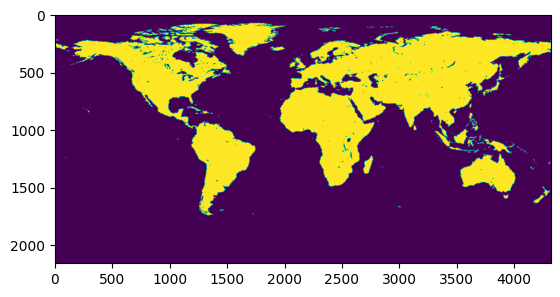

In [33]:
mask.GLDAS_mask.shape

plt.imshow(mask_regrid.GLDAS_mask[0])

In [73]:
lake.amsre

['../data/amsre/monthlies/201001.nc',
 '../data/amsre/monthlies/201002.nc',
 '../data/amsre/monthlies/201003.nc',
 '../data/amsre/monthlies/201004.nc',
 '../data/amsre/monthlies/201005.nc',
 '../data/amsre/monthlies/201006.nc',
 '../data/amsre/monthlies/201007.nc',
 '../data/amsre/monthlies/201008.nc',
 '../data/amsre/monthlies/201009.nc',
 '../data/amsre/monthlies/201010.nc',
 '../data/amsre/monthlies/201011.nc',
 '../data/amsre/monthlies/201012.nc']

In [76]:
def regrid_amsre(month,amsre,modis,weights):
    amsreopen = xr.open_dataset(amsre)
    modisopen = xr.open_dataset(modis)
    regrid = xe.Regridder(amsreopen,modisopen,method='bilinear',weights=weights)
    newargo = regrid(amsreopen)
    newargo.to_netcdf(f'../data/amsre/regrid_to_modis/{month}_amsreregrid.nc')
    return newargo

weights = xr.open_dataset('amsre_to_modis_weights__bilinear_720x1440_2160x4320.nc')

for i in lake.amsre:
    month = re.findall('20[0-9]..[0-9]',i)[0]
    newargo = regrid_amsre(month,i,lake.modis_night[0],weights)
    print(month)

201001
201002
201003
201004
201005
201006
201007
201008
201009
201010
201011
201012


In [33]:
lake.argo[0]

'../data/argo/argo_surfonly/ISAS20_ARGO_20100115_fld_TEMP.nc'

In [50]:
import re
re.findall('20[0-9]..[0-9]',lake.argo[0])[0]

'201001'

In [78]:
amsre_test

<xarray.Dataset>
Dimensions:    (time: 2, lat: 2160, lon: 4320)
Coordinates:
  * time       (time) object 'ascending' 'descending'
  * lat        (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon        (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Data variables:
    sst_month  (time, lat, lon) float32 ...
Attributes:
    regrid_method:  bilinear

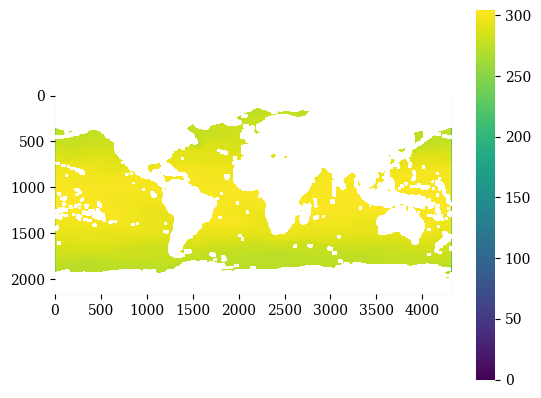

In [83]:
plt.imshow(amsre_test.sst_month[0])
plt.colorbar()

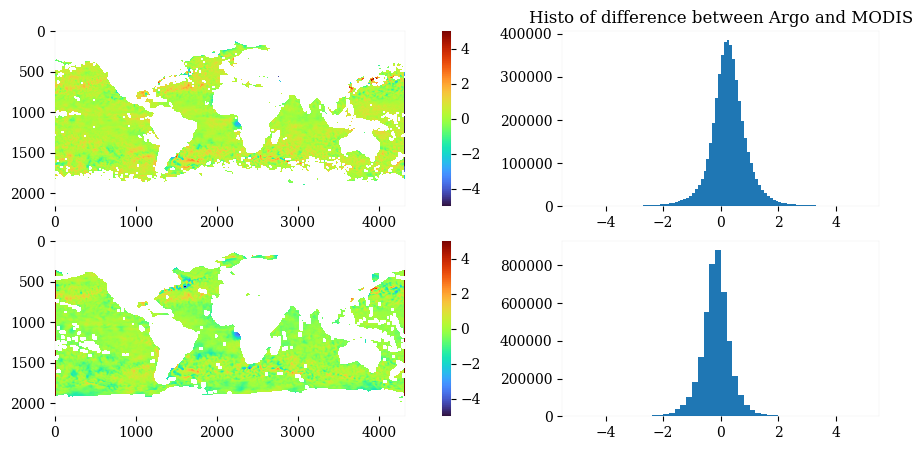

In [94]:
fig = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(2,2,width_ratios=(.7,.3),hspace=.2,wspace=.2)

diff1 = regridded_argo_test.TEMP[0]-modis.sst
amsre_test = xr.open_dataset('../data/amsre/regrid_to_modis/201001_amsreregrid.nc')
diff2 = regridded_argo_test.TEMP[0] - (amsre_test.sst_month[0]-273.15)


fig.add_subplot(gs[0,0])
plt.gca().set_aspect('equal')
plt.imshow(diff,cmap='turbo',vmin=-5,vmax=5)
plt.colorbar(fraction=.02)

fig.add_subplot(gs[0,1])
# plt.gca().set_aspect('equal')
plt.hist(np.asarray(diff).reshape(-1),bins=100,range=(-5,5));
plt.title('Histo (Argo - MODIS)');

fig.add_subplot(gs[1,0])
plt.gca().set_aspect('equal')
plt.imshow(diff2,cmap='turbo',vmin=-5,vmax=5)
plt.colorbar(fraction=.02)

fig.add_subplot(gs[1,1])
# plt.gca().set_aspect('equal')
plt.hist(np.asarray(diff2).reshape(-1),bins=50,range=(-5,5));
plt.title('Histo (Argo - MODIS)');
